This code simulates the observation of 1 satellite from multiple ground stations on earth. It returns the azimuth and elevation of these satellites as seen from the ground stations. The satellite positions are not progoated, but are taken from an ephemeris file.

# Load modules

In [6]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.interface import spice
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup, estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.numerical_simulation.environment import Tle
from datetime import datetime
import matplotlib.dates as mdates
from itertools import zip_longest
from tudatpy.util import result2array

spice.load_standard_kernels()

In [7]:
def sat_prop(
        simulation_start_epoch,
        simulation_end_epoch,
        target,
        target_TLE,
        target_initial_state = None,
        ):
    """
    Propogates the target object

    Parameters:
    simulation_start_epoch: float
        Simulation start epoch, in seconds from J2000
    simulation_end_epoch:
        Simulation end eopch, in sends from J000
    target: str
        Name of celestial body being observed
    target_TLE: tudatpy.kernel.numerical_simulation.environment.Tle object
        TLE of target object. Run TLE values through environment.Tle
    target_initial_state: numpy array
        Contains cartesian position and velocity of target's initial state

    Output:
    states_array: numpy array
        7 column array with time, position and velocities
    """


    # Define string names for bodies to be created from default.
    bodies_to_create = ["Sun", "Earth"]

    # Use "Earth"/"J2000" as global frame origin and orientation.
    global_frame_origin = "Earth"
    global_frame_orientation = "J2000"

    # Create default body settings
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create,
        global_frame_origin,
        global_frame_orientation)
    
    # Create empty body settings for the satellite
    body_settings.add_empty_settings(target)

    bodies = environment_setup.create_system_of_bodies(body_settings)
    # bodies.get(target).mass = 2.2 #kg
    # Define bodies that are propagated
    bodies_to_propagate = [target]

    # Define central bodies of propagation
    central_bodies = ["Earth"]

    # DEFINE ACCELERATIONS ACTING ON TARGET
    accelerations_settings_target = dict(
        Sun=[
            propagation_setup.acceleration.point_mass_gravity()
        ],
        Earth=[
            propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        ]
    )

    # Create global accelerations settings dictionary.
    acceleration_settings = {target: accelerations_settings_target}

    # Create acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies,
        acceleration_settings,
        bodies_to_propagate,
        central_bodies)
    
    if target_initial_state is None:
        target_ephemeris = environment.TleEphemeris("Earth", "J2000", target_TLE, False)
        initial_state = target_ephemeris.cartesian_state(simulation_start_epoch)
    else:
        initial_state = target_initial_state

    

    # Create termination settings
    termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

    # Create numerical integrator settings
    fixed_step_size = 10.0
    integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
        fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
    )

    # Create propagation settings
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        initial_state,
        simulation_start_epoch,
        integrator_settings,
        termination_condition,
    )

    # Create simulation object and propagate the dynamics
    dynamics_simulator = numerical_simulation.create_dynamics_simulator(
        bodies, propagator_settings
    )

    # Extract the resulting state and dependent variable history and convert it to an ndarray
    states = dynamics_simulator.propagation_results.state_history
    states_array = result2array(states)

    return states_array

    

In [ ]:
tle_obj = Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68",
)
# propagate from J2000+0 s to J2000+3600 s
states = sat_prop(
    simulation_start_epoch=0.0,
    simulation_end_epoch=3600.0,
    target="ISS",
    target_TLE=tle_obj,
    target_initial_state=None
)

# Assume `states` is the numpy array from sat_prop:
# columns = [ time, x, y, z, vx, vy, vz ]
states = sat_prop(
    simulation_start_epoch=0.0,
    simulation_end_epoch=3600.0,
    target="ISS",
    target_TLE=tle_obj
)

# Extract time and positions
time = states[:, 0]         # seconds since J2000
x    = states[:, 1]         # x-position (m)
y    = states[:, 2]         # y-position (m)
z    = states[:, 3]         # z-position (m)

# Plot x, y, and z vs time
plt.figure()
plt.plot(time, x, label="x")
plt.plot(time, y, label="y")
plt.plot(time, z, label="z")
plt.xlabel("Time since J2000 (s)")
plt.ylabel("Position (m)")
plt.title("Satellite Position Components Over Time")
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1) Propagate your satellite and get the state history:
#    states[:,0] = time, states[:,1:4] = x,y,z
states = sat_prop(
    simulation_start_epoch=0.0,
    simulation_end_epoch=3600.0,
    target="ISS",
    target_TLE=tle_obj
)

# 2) Extract the position components
x = states[:, 1]
y = states[:, 2]
z = states[:, 3]

# 3) Create a 3D plot
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Orbit Trajectory')

plt.tight_layout()
plt.show()


In [ ]:
def plot_combined_elevation(
        target,
        target_tle,
        station_names,
        start_epoch,
        end_epoch,
        time_step='10m',
        global_frame_origin='Earth',
        global_frame_orientation='J2000',
        geodetic_positions=None):
    """
    Plots elevation of `target` as seen from each ground station in `station_names`.
    """

    # Add 1-hour buffer around user window for tabulated ephemeris
    buffer = 3600.0
    sim_start = start_epoch - buffer
    sim_end   = end_epoch   + buffer

    # 1) Create default Earth + empty target settings (time-limited for efficiency)
    bodies_to_create = ["Earth"]
    body_settings = environment_setup.get_default_body_settings_time_limited(
        bodies_to_create, sim_start, sim_end,
        global_frame_origin, global_frame_orientation)
    body_settings.add_empty_settings(target)

    # 2) Define Earth shape & rotation
    equatorial_radius = 6378e3
    flattening        = 1.0/298.0
    earth_settings    = body_settings.get("Earth")
    earth_settings.shape_settings = environment_setup.shape.oblate_spherical(
        equatorial_radius, flattening)
    

        # Add IERS Earth Rotation Model
    body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
        environment_setup.rotation_model.iau_2006, global_frame_orientation,
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             sim_start, sim_end, 60),
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             sim_start, sim_end, 60),
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             sim_start, sim_end, 60))


    # 3) Build ground-station settings
    ground_settings = []
    for name in station_names:
        if geodetic_positions is None or name not in geodetic_positions:
            raise ValueError(f"No geodetic position for station '{name}'")
        alt, lat_deg, lon_deg = geodetic_positions[name]
        gs = environment_setup.ground_station.basic_station(
            name,
            [alt,
             np.deg2rad(lat_deg),
             np.deg2rad(lon_deg)],
            element_conversion.geodetic_position_type
        )
        ground_settings.append(gs)
    earth_settings.ground_station_settings = ground_settings

    # 4) Tabulate your propagated states into an EphemerisSettings object
    #    (key: epoch→6×1 Cartesian [m & m/s]) :contentReference[oaicite:0]{index=0}
    # First propagate with your sat_prop function
    prop_states = sat_prop(sim_start, sim_end, target, target_tle)
    # Build dict
    state_history = {
        float(row[0]): row[1:].reshape(6, 1)
        for row in prop_states
    }
    body_settings.get(target).ephemeris_settings = (
        environment_setup.ephemeris.tabulated(
            state_history,
            global_frame_origin,
            global_frame_orientation
        )
    )

    # 5) Create the full SystemOfBodies
    bodies = environment_setup.create_system_of_bodies(body_settings)

    # 6) Define one angular_position observable per station :contentReference[oaicite:1]{index=1}
    obs_settings_list = []
    for name in station_names:
        link_ends = {
            observation.receiver: observation.body_reference_point_link_end_id('Earth', name),
        }
        
        link_ends = {
            observation.LinkEnds.ObservationLinkEnd.obs_body:    (target,       ""),
            observation.LinkEnds.ObservationLinkEnd.obs_station: ("Earth", name)
        }
        obs_settings_list.append(
            observation.angular_position(
                link_ends,
                reference_frame_link_ends=(global_frame_origin, global_frame_orientation)
            )
        )

    # 7) Build the simulator
    simulator = numerical_simulation.create_ground_station_observation_simulator(
        bodies, list_of_observable_settings=obs_settings_list
    )

    # 8) Build epochs at which to simulate (parse '10m' → 600 s)
    unit = time_step[-1]
    value = float(time_step[:-1])
    if unit == 'm':
        dt = value * 60.0
    elif unit == 'h':
        dt = value * 3600.0
    elif unit == 's':
        dt = value
    else:
        raise ValueError("time_step must end in 's', 'm', or 'h'")
    epochs = np.arange(start_epoch, end_epoch + dt, dt)

    # 9) Simulate
    observations = simulator.simulate_observations(epochs)

    # 10) Plot elevation for each station
    fig, axes = plt.subplots(len(station_names), 1, figsize=(10, 3*len(station_names)), sharex=True)
    if len(station_names) == 1:
        axes = [axes]
    for ax, name, (obs_id, obs_data) in zip(axes, station_names, observations.items()):
        times      = obs_data[:, 0]
        elevation  = np.degrees(obs_data[:, 2])  # column 2 is elevation [rad → deg]

        ax.plot(times, elevation)
        ax.axhline(0.0, linestyle='--', linewidth=0.5)
        ax.set_title(f"Elevation at {name}")
        ax.set_ylabel("Elevation (°)")
    axes[-1].set_xlabel("Time since J2000 (s)")
    plt.tight_layout()
    plt.show()


In [20]:
tle_obj = Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68",)

# 2) Define your stations and their geodetic positions (alt [m], lat [°], lon [°])
station_names = ["Amsterdam", "London"]
geodetic_positions = {
    "Amsterdam": (  0.0, 52.2,   4.4   ),  # alt=0 m, lat=52.2°N, lon=4.4°E
    "London":    ( 45.0, 51.5,  -0.13  )   # alt=45 m, lat=51.5°N, lon=0.13°W
}

# 3) Choose a 2-hour window starting at J2000 + 0 s
start_epoch = 0.0           # J2000 + 0 s
end_epoch   = 2 * 3600.0    # J2000 + 2 h

# 4) Call the plotting function
plot_combined_elevation(
    target                 = "ISS",
    target_tle             = tle_obj,
    station_names          = station_names,
    start_epoch            = start_epoch,
    end_epoch              = end_epoch,
    time_step              = "10m",             # sample every 10 minutes
    global_frame_origin    = "Earth",
    global_frame_orientation = "J2000",
    geodetic_positions     = geodetic_positions
)

AttributeError: module 'tudatpy.kernel.numerical_simulation.estimation_setup.observation' has no attribute 'LinkEnds'

In [ ]:
def plot_combined_elevation(
        target,
        target_tle, 
        station_names, 
        start_epoch, 
        end_epoch, 
        time_step = '10m',
        global_frame_origin = 'Earth', 
        global_frame_orientation = 'J2000', 
        geodetic_positions = None,):

    """
    Plots the combined elevation of a target celestial body as seen from multiple ground stations.

    Parameters:
    -----------
    target : str
        Name of the celestial body being observed.
    target_tle : tudatpy.kernel.numerical_simulation.environment.Tle object
        TLE of target object. Run TLE values through environment.Tle
    station_names : list of str
        List of ground station names from which the target's elevation is to be computed.
    start_epoch : float
        Start epoch of the observation in seconds since J2000
    end_epoch : float
        End epoch of the observation in seconds since J2000
    time_step : str, optional (default='10m')
        Time step for ephemeris queries (e.g., '10m' for 10 minutes).
    global_frame_origin : str, optional (default='Earth')
        Origin of the global reference frame.
    global_frame_orientation : str, optional (default='J2000')
        Orientation of the global reference frame.
    geodetic_positions : dict, optional (default=None)
        Dictionary containing geodetic positions (altitude, latitude, longitude) for ground stations not present in Tudat's default list.

    Returns:
    --------
    None
        This function generates a plot of the elevation angles for the target as seen from the specified ground stations.
    """

    bodies_to_create = ["Earth"]



    # Add a buffer to the user-defined start and end epochs.
    n_second_buffer = 3600
    simulation_seconds_start_epoch = start_epoch-n_second_buffer
    simulation_seconds_end_epoch = end_epoch+n_second_buffer

    # Actual (user-queried) start epoch. Later on, we will filter our results based on this epoch.
    actual_seconds_start_epoch  = start_epoch
    actual_seconds_end_epoch  = end_epoch

    # Create default Earth and target settings. Using time limited settings helps code run faster
    body_settings = environment_setup.get_default_body_settings_time_limited(
        bodies_to_create, simulation_seconds_start_epoch, simulation_seconds_end_epoch, global_frame_origin, global_frame_orientation)
    body_settings.add_empty_settings(target)

    # # Add Earth's shape settings. 
    # # We go for an oblate spherical shape, using a radius of 6378 km and the current accepted flattening value

    equatorial_radius = 6378*1e3 # in meters
    flattening = 1/298
    body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical(
        equatorial_radius = equatorial_radius,
        flattening = flattening,
    )

    # Add IERS Earth Rotation Model
    body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
        environment_setup.rotation_model.iau_2006, global_frame_orientation,
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             simulation_seconds_start_epoch, simulation_seconds_end_epoch, 60),
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             simulation_seconds_start_epoch, simulation_seconds_end_epoch, 60),
        interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                             simulation_seconds_start_epoch, simulation_seconds_end_epoch, 60))
    

    # Initialize the (sub)plots.
    fig, axes = plt.subplots(len(station_names), 1, figsize=(17, 15))
    fig.tight_layout(pad=5)  # Adjust padding between subplots


    ground_stations_settings = list()
    geodetic_stations_dict = geodetic_positions
    horizons_coordinates_dict = dict()

    for current_station in station_names:
        if not geodetic_positions:
            print(f'Station: {current_station} not found in Tudat list of stations, and no custom geodetic position found in the geodetic_position dictionary.\n'
                    f'Please provide it.\n Aborting...')
            exit()
        elif geodetic_positions and not geodetic_positions[current_station]:
            print(f'Geodetic Position for {current_station} not found in the geodetic_position dictionary. Please provide it.\n Aborting...')
            exit()
        if current_station not in geodetic_positions.keys():
            print(f'Station Location for station: {current_station} not found in Tudat list of stations, '
                    f'nor in ground_station_positions. Please provide a valid geodetic location.'
                    )
            exit()

        else:
            geodetic_position = geodetic_positions[current_station]
            ground_stations_settings.append( environment_setup.ground_station.basic_station(
                current_station,
                [geodetic_position[0], # in meters
                    np.deg2rad(geodetic_position[1]), # latitude in radians
                    np.deg2rad(geodetic_position[2]) # longitude in radians
                    ],
                element_conversion.geodetic_position_type
            ))


            horizons_coordinates_dict[current_station] = {
                'lon': geodetic_position[2], # in degrees
                'lat': geodetic_position[1], # in degrees
                'elevation': geodetic_position[0]/1000, # in km
            }

    body_settings.get('Earth').ground_station_settings =  ground_stations_settings

    # In order to visualize the plot better, we also decide to record the rise and set times (if any) over the user-specified timespan.
    # These are defined as the points in time where the target rises above or sets below the local horizon, on a given topocentric location.
    rise_set_times_dict = dict()
    for idx, station_name in enumerate(station_names):
        horizons_coord = horizons_coordinates_dict[station_name]
        ground_stations_setting = ground_stations_settings[idx]


        target_prop_states_cart = sat_prop(
            simulation_seconds_start_epoch,
            simulation_seconds_end_epoch,
            target,
            target_tle,
            target_initial_state=None
        )

            # Build dict
        state_history = {
            float(row[0]): row[1:].reshape(6, 1)
            for row in target_prop_states_cart
        }
        body_settings.get(target).ephemeris_settings = (
            environment_setup.ephemeris.tabulated(
                state_history,
                global_frame_origin,
                global_frame_orientation
            )
        )


        # We struggled quite a bit to set all the body settings, but now we can finally create our bodies object.
        bodies = environment_setup.create_system_of_bodies(body_settings)
        print(ground_stations_settings)
        
        # environment_setup.add_ground_station(
        #     bodies.get("Earth"),
        #     ground_stations_setting
        # )

        # Notice how - so far - we have not run any simulation yet. 
        # As we approach doing that, it is time to create the link ends for the simulation. 
        # The given antenna is set as a receiver through the function: 'body_reference_point_link_end_id' of the observation module. 
        # (See: https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.body_reference_point_link_end_id)
        link_ends = {
            observation.receiver: observation.body_reference_point_link_end_id('Earth', station_name),
        }
        # Create a single link definition from the link ends
        link_definition = observation.LinkDefinition(link_ends)

        # Finally, the Tudat function 'compute_target_angles_and_range' can be used to simulate the observed azimuth and elevation 
        # from the given receiver, at the given observation times (notice how we filter tudat_seconds_ephemeris by start_end_condition)
        # as we only want to cover the user-defined timespan. 
        station_id = ('Earth', station_name)
        tudat_seconds_ephemeris = np.linspace(simulation_seconds_start_epoch, simulation_seconds_end_epoch, int(time_step.strip('m'))*10)
        angles_range_dictionary = estimation.compute_target_angles_and_range(
            bodies,
            station_id,
            target,
            observation_times=tudat_seconds_ephemeris,
            is_station_transmitting=False
        )

        # Initialize lists for azimuth and elevation
        tudat_azimuth_list = []
        tudat_elevation_list = []

        # The following code snippet allows to compute the rise and set times, as seen from each station, 
        # and to populate the rise_set_dict dictionary. 
        set_times = []
        rise_times = []
        keys_list = sorted(angles_range_dictionary.keys())

        initial_elevation = np.rad2deg(angles_range_dictionary[keys_list[0]][0])
        flag = initial_elevation <= 0  # True if initially below horizon

        for idx_key, key in enumerate(keys_list):  # Ensure iteration follows sorted order
            azimuth_deg = np.rad2deg(angles_range_dictionary[key][1]) % 360
            elevation_deg = (np.rad2deg(angles_range_dictionary[key][0]) + 90) % 180 - 90  # Normalize elevation
            tudat_azimuth_list.append(azimuth_deg)
            tudat_elevation_list.append(elevation_deg)

            if elevation_deg > 0:  # Object above horizon
                if flag:  # Transition from below horizon to above
                    rise_times.append(tudat_datetime_times[idx_key])
                    flag = False  # Update flag
            else:  # Object below horizon
                if not flag:  # Transition from above horizon to below
                    set_times.append(tudat_datetime_times[idx_key])
                    flag = True  # Update flag

        rise_set_times_dict[station_name] = [rise_times, set_times]
        rise_times = rise_set_times_dict[station_name][0]
        set_times = rise_set_times_dict[station_name][1]

        # Convert to numpy arrays
        azimuth_array = np.array(tudat_azimuth_list)
        elevation_array = np.array(tudat_elevation_list)

        # The last bit of this Jupyter Notebook deals with visualization of the obtained data. 
        # Antennas observing at low elevation quickly lose performance. Moreover, if the elvation is negative, the target is not observable.
        # That is why we plot horizontal lines at 15 degrees and 0 degrees.
        if len(station_names) == 1:
            if not custom_ephemeris:
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_elevation[horizons_elevation > 15], label=f"Horizons Elevation",
                                  s=10, c='pink', alpha=1)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_azimuth[horizons_elevation > 15], label=f"Horizons Azimuth",
                                  s=10, c='green', alpha=1)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_elevation[horizons_elevation <= 15],
                                  s=7, c='pink', alpha=0.3)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_azimuth[horizons_elevation <= 15],
                                  s=7, c='green', alpha=0.3)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_elevation[horizons_elevation <= 0],
                                  s=5, c='pink', alpha=0.1)
                axes.scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_azimuth[horizons_elevation <= 0],
                                  s=5, c='green', alpha=0.1)

            axes.scatter(np.array(tudat_datetime_times)[elevation_array > 15], elevation_array[elevation_array > 15],
                              s=5, label='Tudat Elevation', c='blue')
            axes.scatter(np.array(tudat_datetime_times)[elevation_array > 15], azimuth_array[elevation_array > 15],
                              s=5, label='Tudat Azimuth', c='red')
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 15], elevation_array[elevation_array <= 15],
                              s=3, c='blue', alpha=0.5)
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 15], azimuth_array[elevation_array <= 15],
                              s=3, c='red', alpha=0.5)
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 0], elevation_array[elevation_array <= 0],
                              s=1, c='blue', alpha=0.1)
            axes.scatter(np.array(tudat_datetime_times)[elevation_array <= 0], azimuth_array[elevation_array <= 0],
                              s=1, c='red', alpha=0.1)

            # Add a horizontal line for elevation = 15
            axes.axhline(y=15, color='k', linestyle='--', alpha=0.5, label = '15 deg')
            axes.axhline(y=0, color='green', linestyle='--', alpha=0.5, label = '0 deg')

            for i in range(len(set_times)):
                if i == 0:
                    axes.axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5, label = 'Set times')
                else:
                    axes.axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5)

            for i in range(len(rise_times)):
                if i == 0:
                    axes.axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5, label = 'Rise times')
                else:
                    axes.axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5)

            # Add labels, title, and legend
            axes.set_xlabel('UTC Time')
            axes.set_ylabel('Elevation/Azimuth (Degrees)')
            axes.set_title(f'{target} from {station_name}')
            axes.legend(loc='upper right')

            # Use zip_longest to pair rise_times and set_times, filling missing values with None
            for rise_time, set_time in zip_longest(rise_times, set_times, fillvalue=None):
                
                if not set_time and rise_time:  # If only rise_time exists
                    print(f'Rise from {station_name}:', rise_time)
                elif not rise_time and set_time:  # If only set_time exists
                    print(f'Set from {station_name}:', set_time)
                elif not rise_time and not set_time:  # If neither exists
                    print(f'No rise nor set for {station_name} in the selected timespan.')
                else:  # If both exist
                    print(f'Rise from {station_name}:', rise_time, f'Set from {station_name}:', set_time)

            # Customize x-axis ticks (datetime formatting and positioning)
            axes.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d\n%H:%M'))
            axes.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=30, maxticks=30))
            axes.grid()
            axes.tick_params(axis='x', labelsize=7)  # Adjust 'labelsize' to the desired font size

        else:
            # Horizons will be able to give an Elevation plot only when  custom_ephemeris == False or None
            if not custom_ephemeris: 
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_elevation[horizons_elevation > 15], label=f"Horizons Elevation",
                                  s=20, c='pink', alpha=0.5, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation > 15], horizons_azimuth[horizons_elevation > 15], label=f"Horizons Azimuth",
                                  s=20, c='green', alpha=0.5, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_elevation[horizons_elevation <= 15],
                                  s=15, c='pink', alpha=0.3, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 15], horizons_azimuth[horizons_elevation <= 15],
                              s=15, c='green', alpha=0.3, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_elevation[horizons_elevation <= 0],
                                  s=10, c='pink', alpha=0.1, marker = 's')
                axes[idx].scatter(np.array(horizons_datetime_times)[horizons_elevation <= 0], horizons_azimuth[horizons_elevation <= 0],
                              s=10, c='green', alpha=0.1, marker = 's')
                
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array > 15], elevation_array[elevation_array > 15],
                              s=5, label='Tudat Elevation', c='blue')
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array > 15], azimuth_array[elevation_array > 15],
                              s=5, label='Tudat Azimuth', c='black')
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 15], elevation_array[elevation_array <= 15],
                              s=3, c='blue', alpha=0.5)
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 15], azimuth_array[elevation_array <= 15],
                              s=3, c='black', alpha=0.5)
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 0], elevation_array[elevation_array <= 0],
                              s=1, c='blue', alpha=0.1)
            axes[idx].scatter(np.array(tudat_datetime_times)[elevation_array <= 0], azimuth_array[elevation_array <= 0],
                              s=1, c='black', alpha=0.1)

            # Add a horizontal line for elevation = 15
            axes[idx].axhline(y=15, color='k', linestyle='--', alpha=0.5, label = '15 deg')
            axes[idx].axhline(y=0, color='green', linestyle='--', alpha=0.5, label = '0 deg')

            for i in range(len(set_times)):
                if i == 0:
                    axes[idx].axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5, label = 'Set times')
                else:
                    axes[idx].axvline(x = set_times[i], color='grey', linestyle='--', alpha=0.5)

            for i in range(len(rise_times)):
                if i == 0:
                    axes[idx].axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5, label = 'Rise times')
                else:
                    axes[idx].axvline(x = rise_times[i], color='purple', linestyle='--', alpha=0.5)

            # Add labels, title, and legend
            axes[idx].set_xlabel('UTC Time')
            axes[idx].set_ylabel('Elevation/Azimuth (Degrees)')
            axes[idx].set_title(f'{target} Az/El from {station_name}')
            axes[idx].legend(loc='upper right')

            # Use zip_longest to pair rise_times and set_times, filling missing values with None
            for rise_time, set_time in zip_longest(rise_times, set_times, fillvalue=None):
                
                if not set_time and rise_time:  # If only rise_time exists
                    print(f'Rise from {station_name}:', rise_time)
                elif not rise_time and set_time:  # If only set_time exists
                    print(f'Set from {station_name}:', set_time)
                elif not rise_time and not set_time:  # If neither exists
                    print(f'No rise nor set for {station_name} in the selected timespan.')
                else:  # If both existx1
                    print(f'Rise from {station_name}:', rise_time, f'Set from {station_name}:', set_time)
        
            # Customize x-axis ticks (datetime formatting and positioning)
            axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d\n%H:%M'))
            axes[idx].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=20))
            axes[idx].grid()
            axes[idx].tick_params(axis='x', labelsize=7)  # Adjust 'labelsize' to the desired font size


    # Show the combined plot
    plt.show()





[<tudatpy.kernel.numerical_simulation.environment_setup.ground_station.GroundStationSettings object at 0x00000272EC8BBBF0>, <tudatpy.kernel.numerical_simulation.environment_setup.ground_station.GroundStationSettings object at 0x00000272EB7190F0>]
Rise from KATH12M: 2022-12-19 12:40:00.000983 Set from KATH12M: 2022-12-19 02:00:00.001019
[<tudatpy.kernel.numerical_simulation.environment_setup.ground_station.GroundStationSettings object at 0x00000272EC8BBBF0>, <tudatpy.kernel.numerical_simulation.environment_setup.ground_station.GroundStationSettings object at 0x00000272EB7190F0>]
Rise from YARRA12M: 2022-12-19 12:40:00.000983 Set from YARRA12M: 2022-12-19 02:00:00.001019


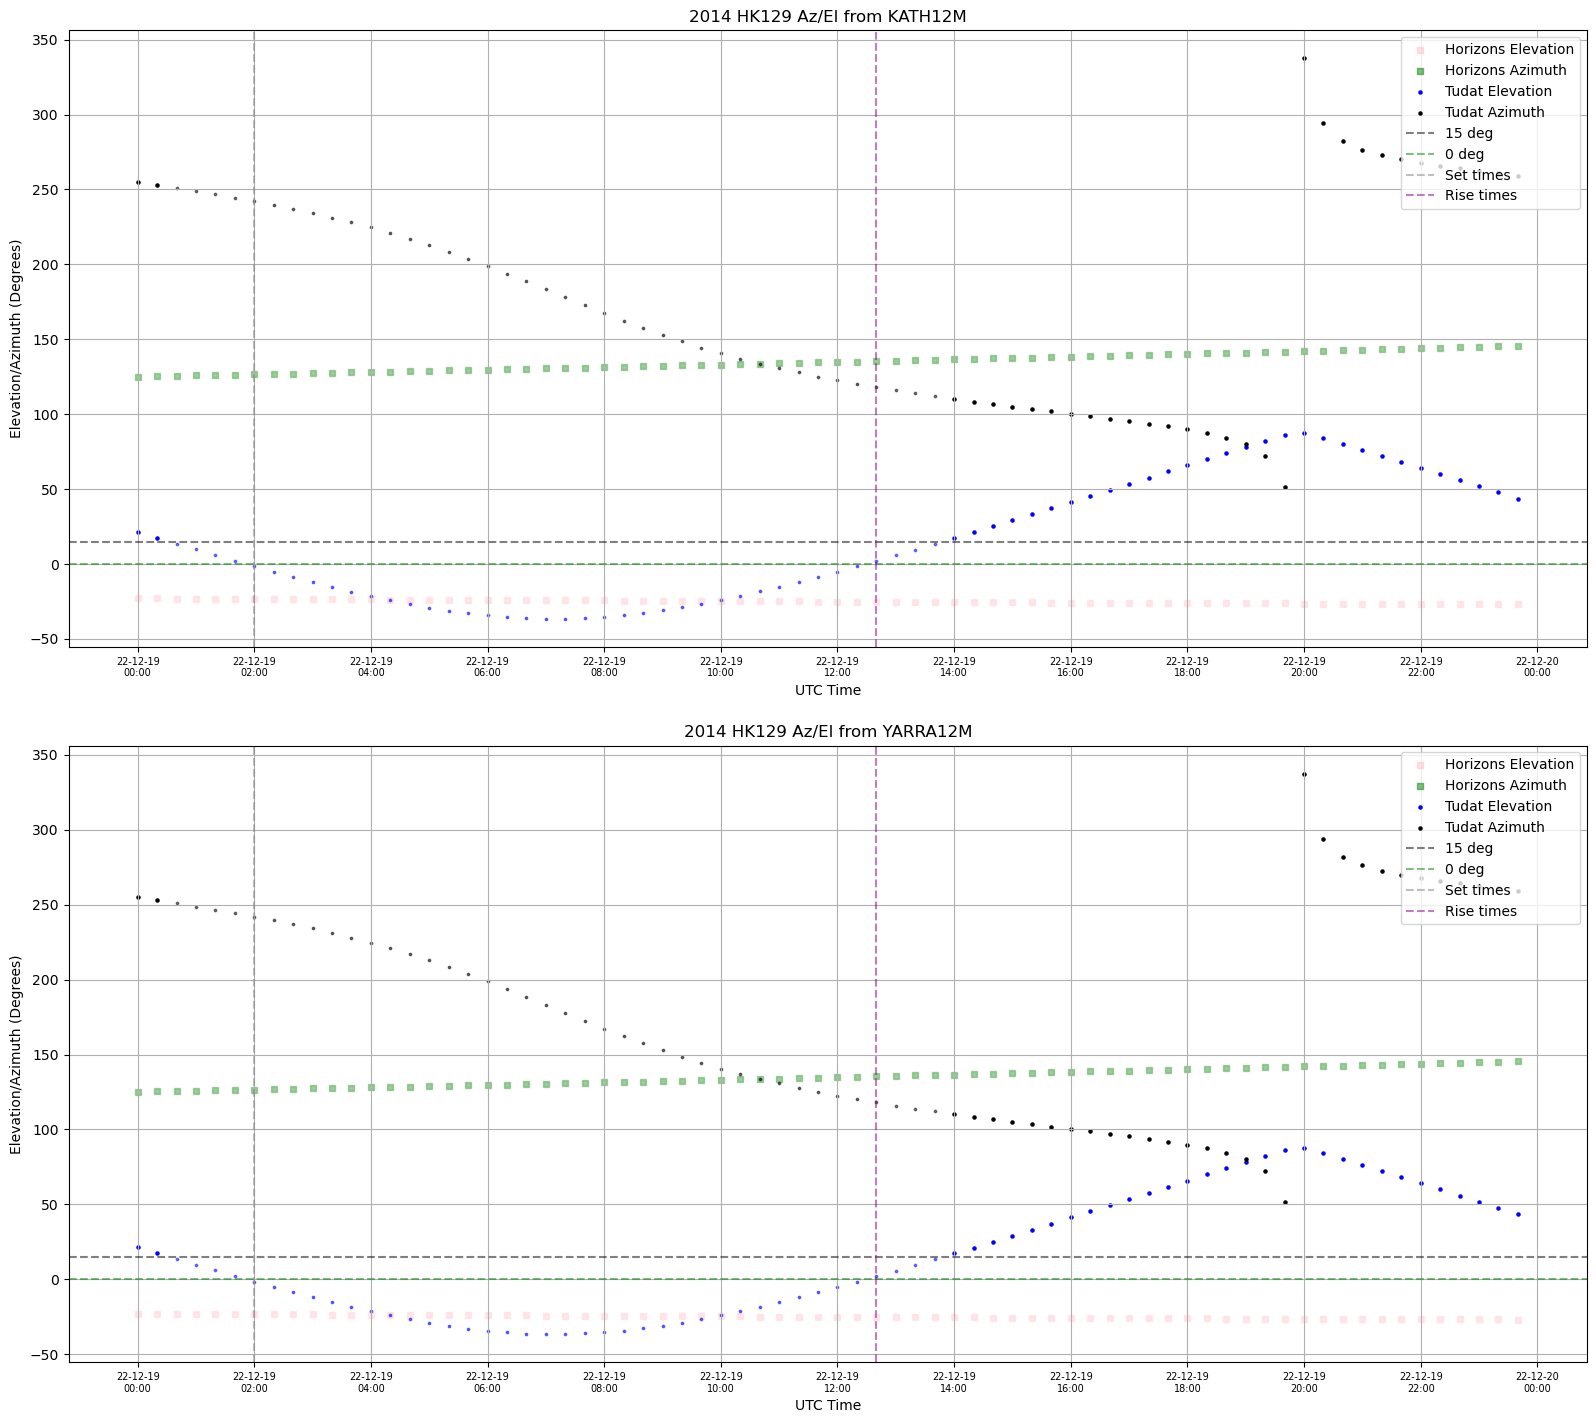

In [6]:
# Select station names

station_names =['KATH12M','YARRA12M']
# station_names =['YARRA12M']

# Here, we trick tudat by changing the (already defined in the tudat list of stations) position for KATH12M.
# Hence, we will expect to have the same exact plot for both Yarragadee and Katherine.
# We do this in order to show how an already-existing Tudat station location (such as the one of KATH12M) can be overwritten by the user.  
geodetic_positions = {'KATH12M':[250,-29.0464, 115.3456],'YARRA12M': [250,-29.0464, 115.3456] }
# geodetic_positions = {'YARRA12M': [250,-29.0464, 115.3456]}

# Select the global frame and orientation 
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'

# Retrieving Horizons + Tudat Az/El plot for given start and end epochs
start_epoch = '2022-12-19 00:00:00'
end_epoch = '2022-12-20 00:00:00'

plot_combined_elevation(
    '2014 HK129',
    station_names,
    start_epoch = start_epoch,
    end_epoch = end_epoch,
    time_step= '20m',
    geodetic_positions=geodetic_positions,
    custom_ephemeris = None
)